In [11]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Fetch Historical Data ---
def fetch_data(instrument="EUR_USD", granularity="H1", count=10000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693",
                 environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)
    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c'])
    } for candle in r.response['candles']]
    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close']].copy()

# --- Step 2: Detect Swing Highs/Lows (Fixed) ---
def detect_swings(df, window=30):
    df = df.copy()
    df['swing_high'] = df['high'].rolling(window=window, center=False).max().shift()
    df['swing_low'] = df['low'].rolling(window=window, center=False).min().shift()

    df['swing_high'] = np.where(df['high'] == df['swing_high'], df['high'], np.nan)
    df['swing_low'] = np.where(df['low'] == df['swing_low'], df['low'], np.nan)

    df['swing_high'] = df['swing_high'].ffill(limit=window)
    df['swing_low'] = df['swing_low'].ffill(limit=window)

    return df

# --- Step 3: Calculate Fibonacci Levels From Last Swing ---
def calculate_fib_levels(df):
    df = df.copy()
    df['diff'] = df['swing_high'] - df['swing_low']
    df['Level_0.382'] = df['swing_high'] - 0.382 * df['diff']
    df['Level_0.618'] = df['swing_high'] - 0.618 * df['diff']
    return df

# --- Step 4: Apply Strategy Logic – Fib + EMA Trend Filter ---
def apply_strategy(df, tolerance=0.0025):  # 0.25%
    df = df.copy()
    capital = 10000
    risk_per_trade = 0.01  # 1% per trade
    fixed_sl_pips = 0.0020  # 20 pips
    fixed_rr_ratio = 2.0  # TP = 2x SL

    # Trend Filter
    df['ema_200'] = df['close'].ewm(200).mean()
    df['trend'] = np.where(df['close'] > df['ema_200'], 'Uptrend', 'Downtrend')

    # Entry Signal – Buy when price near 0.618 AND trend matches
    df['buy_signal'] = ((df['trend'] == 'Uptrend') &
                        (abs(df['close'] - df['Level_0.618']) / df['close'] < tolerance))
    df['sell_signal'] = ((df['trend'] == 'Downtrend') &
                         (abs(df['close'] - df['Level_0.618']) / df['close'] < tolerance))

    # Track entry price
    df['entry_price'] = np.nan
    df.loc[df['buy_signal'], 'entry_price'] = df['close']
    df.loc[df['sell_signal'], 'entry_price'] = df['close']
    df['entry_price'] = df['entry_price'].ffill().fillna(0)

    # Stop Loss & Take Profit
    df['sl_long'] = df['entry_price'] - fixed_sl_pips
    df['tp_long'] = df['entry_price'] + fixed_sl_pips * fixed_rr_ratio
    df['sl_short'] = df['entry_price'] + fixed_sl_pips
    df['tp_short'] = df['entry_price'] - fixed_sl_pips * fixed_rr_ratio

    # Exit Signals
    df['exit_long'] = (df['close'] <= df['sl_long']) | (df['close'] >= df['tp_long'])
    df['exit_short'] = (df['close'] >= df['sl_short']) | (df['close'] <= df['tp_short'])

    # Generate Positions
    df['position'] = np.nan
    df.loc[df['buy_signal'], 'position'] = 1
    df.loc[df['sell_signal'], 'position'] = -1
    df.loc[df['exit_long'] | df['exit_short'], 'position'] = 0
    df['position'] = df['position'].ffill().fillna(0)

    # Position Sizing Based on Risk
    df['position_size'] = (capital * risk_per_trade) / fixed_sl_pips
    df['position_size'] = df['position_size'].clip(upper=100000)  # Cap position size

    # PnL Calculation
    long_return = ((df['close'] - df['entry_price']) / fixed_sl_pips) * risk_per_trade
    short_return = ((df['entry_price'] - df['close']) / fixed_sl_pips) * risk_per_trade
    df['pnl'] = np.where(df['position'] == 1, long_return,
                         np.where(df['position'] == -1, short_return, 0))
    df['pnl'] = df['pnl'].replace([np.inf, -np.inf], 0).fillna(0)
    df['strategy_returns'] = df['pnl'].shift()
    df['equity_curve'] = (df['strategy_returns'] + 1).cumprod() * capital

    return df

📊 Running Fib Pullback Strategy Across Multiple Instruments:



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\85755280.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 16)



📊 EUR_USD
 Backtest Period: 2024-08-21 01:00:00+00:00 → 2025-06-11 08:00:00+00:00
 Duration: ~0.8 years
 Total Return: 0.00%
 Win Rate: 0.0%
 Max Drawdown: 0.00%
 Profit Factor: inf
 Sharpe Ratio: nan
 Final Equity: $10000.00


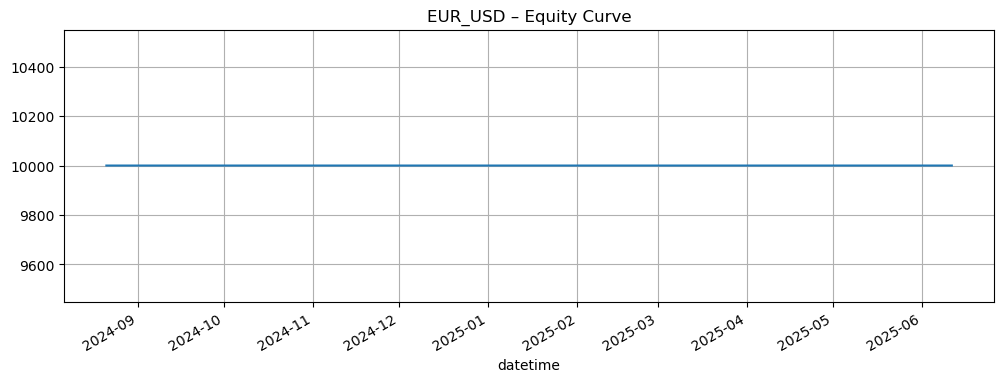

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\85755280.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 16)



📊 GBP_USD
 Backtest Period: 2024-08-21 01:00:00+00:00 → 2025-06-11 08:00:00+00:00
 Duration: ~0.8 years
 Total Return: 0.00%
 Win Rate: 0.0%
 Max Drawdown: 0.00%
 Profit Factor: inf
 Sharpe Ratio: nan
 Final Equity: $10000.00


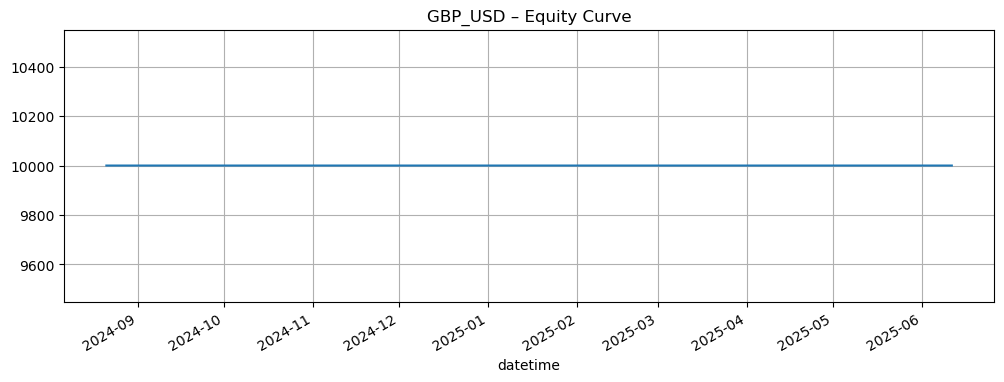


📊 AUD_USD
 Backtest Period: 2024-08-21 01:00:00+00:00 → 2025-06-11 08:00:00+00:00
 Duration: ~0.8 years
 Total Return: 0.40%
 Win Rate: 50.0%
 Max Drawdown: 0.00%
 Profit Factor: inf
 Sharpe Ratio: 0.90
 Final Equity: $10040.00


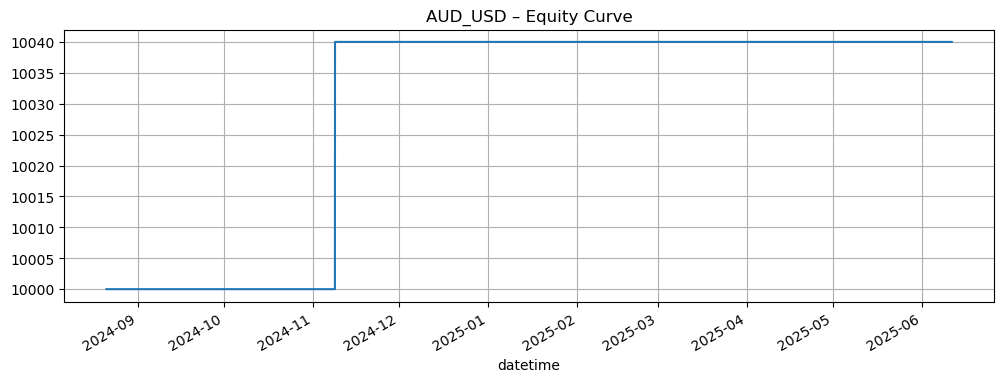

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\85755280.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 16)



📊 NZD_USD
 Backtest Period: 2024-08-21 01:00:00+00:00 → 2025-06-11 08:00:00+00:00
 Duration: ~0.8 years
 Total Return: 0.00%
 Win Rate: 0.0%
 Max Drawdown: 0.00%
 Profit Factor: inf
 Sharpe Ratio: nan
 Final Equity: $10000.00


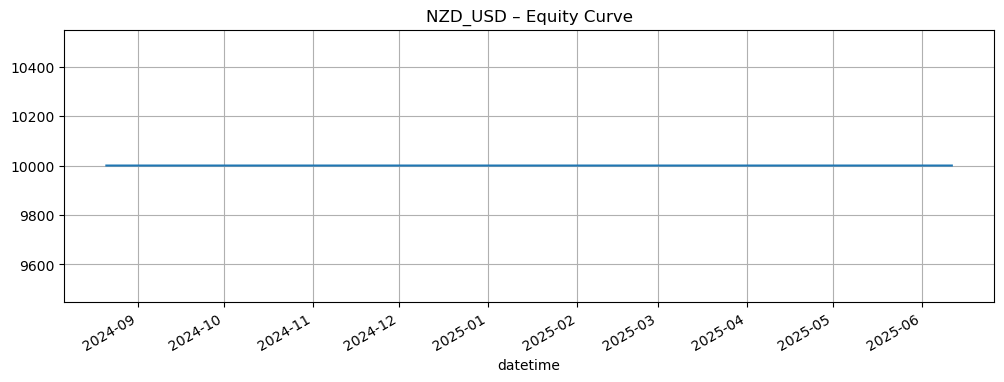


📊 USD_CHF
 Backtest Period: 2024-08-21 01:00:00+00:00 → 2025-06-11 08:00:00+00:00
 Duration: ~0.8 years
 Total Return: 8.32%
 Win Rate: 82.1%
 Max Drawdown: 0.16%
 Profit Factor: 19.85
 Sharpe Ratio: 3.76
 Final Equity: $10831.97


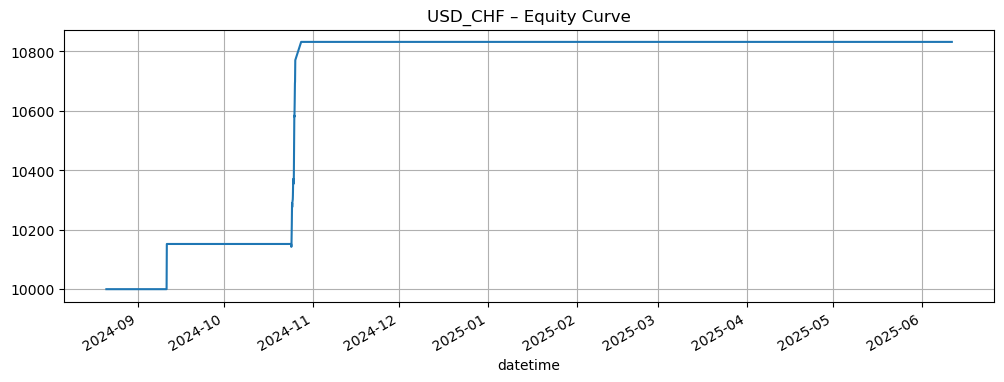

In [15]:
# --- Step 5: List of Instruments To Test ---
instruments = ["EUR_USD", "GBP_USD", "AUD_USD", "NZD_USD", "USD_CHF"]
summary = []

print("📊 Running Fib Pullback Strategy Across Multiple Instruments:\n")

for instrument in instruments:
    try:
        df = fetch_data(instrument, count=5000)
        df = detect_swings(df, window=30)
        df = calculate_fib_levels(df)
        df = apply_strategy(df)

        total_return = (df['equity_curve'].iloc[-1] - 10000) / 10000 * 100
        num_trades = df['position'].diff().abs().sum() / 2
        win_rate = np.mean(df['strategy_returns'][df['strategy_returns'] != 0] > 0) if any(df['strategy_returns'] != 0) else 0

        # Sharpe Ratio
        sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 16)

        # Profit Factor
        gross_profit = df['strategy_returns'][df['strategy_returns'] > 0].sum()
        gross_loss = abs(df['strategy_returns'][df['strategy_returns'] < 0].sum())
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

        # Max Drawdown
        df['peak'] = df['equity_curve'].cummax()
        df['drawdown'] = (df['peak'] - df['equity_curve']) / df['peak'] * 100
        max_drawdown = df['drawdown'].max()

        # Time Range
        start_date = df.index[0]
        end_date = df.index[-1]
        years = (end_date - start_date).days / 365

        print(f"\n📊 {instrument}")
        print(f" Backtest Period: {start_date} → {end_date}")
        print(f" Duration: ~{years:.1f} years")
        print(f" Total Return: {total_return:.2f}%")
        print(f" Win Rate: {win_rate * 100:.1f}%")
        print(f" Max Drawdown: {max_drawdown:.2f}%")
        print(f" Profit Factor: {profit_factor:.2f}")
        print(f" Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f" Final Equity: ${df['equity_curve'].iloc[-1]:.2f}")

        summary.append({
            'Instrument': instrument,
            'Total Return (%)': total_return,
            'Win Rate (%)': win_rate * 100,
            'Max Drawdown (%)': max_drawdown,
            'Profit Factor': profit_factor,
            'Sharpe Ratio': sharpe_ratio,
            'Trades Taken': int(num_trades),
            'Start Date': start_date,
            'End Date': end_date
        })

        # Plot equity curve
        df['equity_curve'].plot(title=f"{instrument} – Equity Curve", figsize=(12, 4), grid=True)
        plt.show()

    except Exception as e:
        print(f"📊 Error on {instrument}: {str(e)}")
        summary.append({
            'Instrument': instrument,
            'Total Return (%)': np.nan,
            'Win Rate (%)': np.nan,
            'Max Drawdown (%)': np.nan,
            'Profit Factor': np.nan,
            'Sharpe Ratio': np.nan,
            'Trades Taken': 0
        })

📊 Running Fib Pullback Strategy Across Multiple Instruments:



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_high'] = df['high'][argrelextrema(df['high'].values, np.greater, order=window)[0]]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_low'] = df['low'][argrelextrema(df['low'].values, np.less, order=window)[0]]



📊 EUR_USD
 Backtest Period: 2025-03-31 07:15:00+00:00 → 2025-06-11 09:00:00+00:00
 Duration: ~0.2 years
 Total Return: 9.20%
 Win Rate: 56.9%
 Max Drawdown: 12.37%
 Profit Factor: 1.17
 Sharpe Ratio: 1.35
 Final Equity: $10919.67


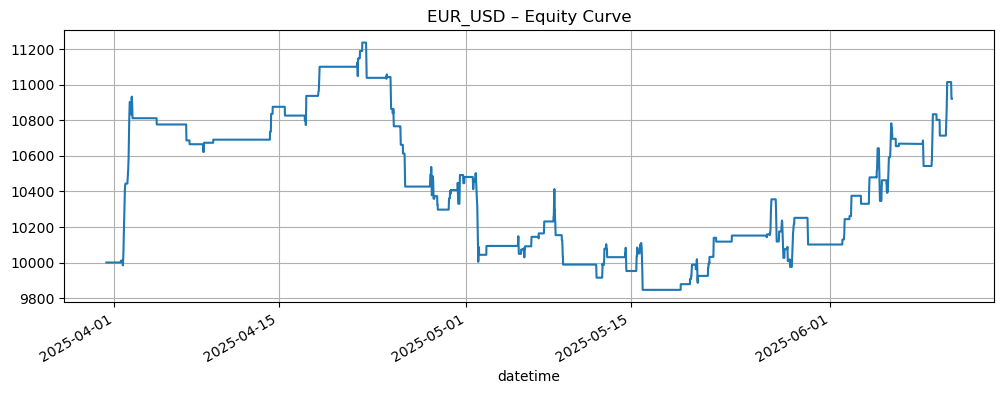

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_high'] = df['high'][argrelextrema(df['high'].values, np.greater, order=window)[0]]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_low'] = df['low'][argrelextrema(df['low'].values, np.less, order=window)[0]]



📊 GBP_USD
 Backtest Period: 2025-03-31 07:00:00+00:00 → 2025-06-11 09:00:00+00:00
 Duration: ~0.2 years
 Total Return: 42.28%
 Win Rate: 63.4%
 Max Drawdown: 4.46%
 Profit Factor: 1.94
 Sharpe Ratio: 5.54
 Final Equity: $14228.02


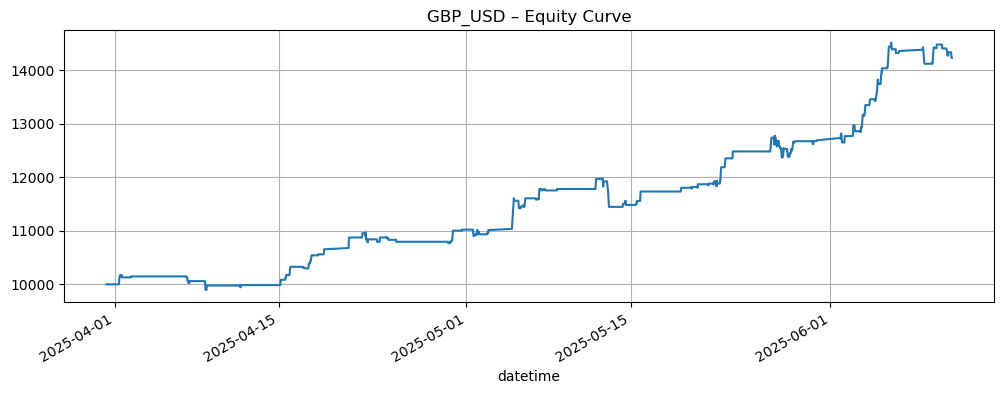

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_high'] = df['high'][argrelextrema(df['high'].values, np.greater, order=window)[0]]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_low'] = df['low'][argrelextrema(df['low'].values, np.less, order=window)[0]]



📊 AUD_USD
 Backtest Period: 2025-03-31 07:15:00+00:00 → 2025-06-11 09:00:00+00:00
 Duration: ~0.2 years
 Total Return: 25.57%
 Win Rate: 55.4%
 Max Drawdown: 8.99%
 Profit Factor: 1.33
 Sharpe Ratio: 2.96
 Final Equity: $12556.87


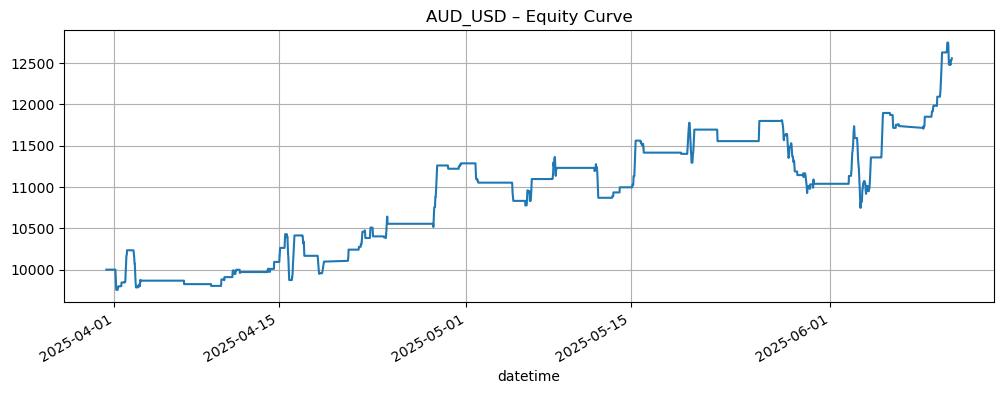

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_high'] = df['high'][argrelextrema(df['high'].values, np.greater, order=window)[0]]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_low'] = df['low'][argrelextrema(df['low'].values, np.less, order=window)[0]]



📊 NZD_USD
 Backtest Period: 2025-03-31 07:15:00+00:00 → 2025-06-11 09:00:00+00:00
 Duration: ~0.2 years
 Total Return: 17.99%
 Win Rate: 53.6%
 Max Drawdown: 13.94%
 Profit Factor: 1.28
 Sharpe Ratio: 2.36
 Final Equity: $11799.38


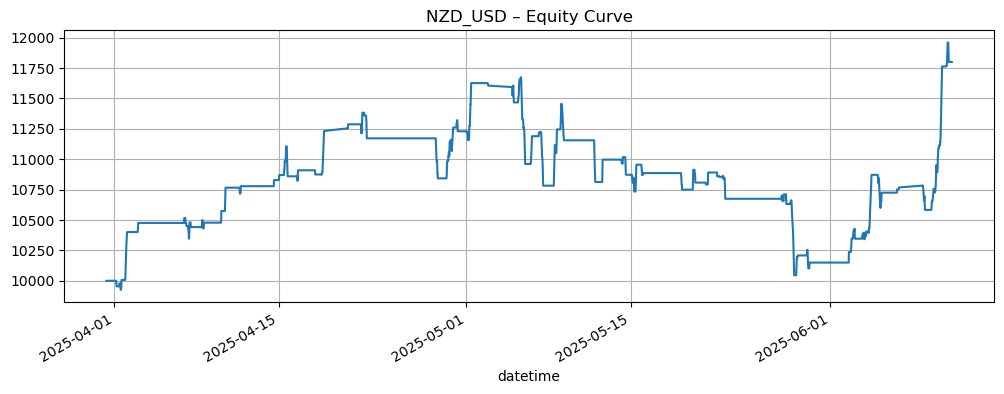

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_high'] = df['high'][argrelextrema(df['high'].values, np.greater, order=window)[0]]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19728\401207066.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['swing_low'] = df['low'][argrelextrema(df['low'].values, np.less, order=window)[0]]



📊 USD_CHF
 Backtest Period: 2025-03-31 07:00:00+00:00 → 2025-06-11 09:00:00+00:00
 Duration: ~0.2 years
 Total Return: -0.50%
 Win Rate: 51.3%
 Max Drawdown: 17.88%
 Profit Factor: 1.00
 Sharpe Ratio: -0.04
 Final Equity: $9949.51


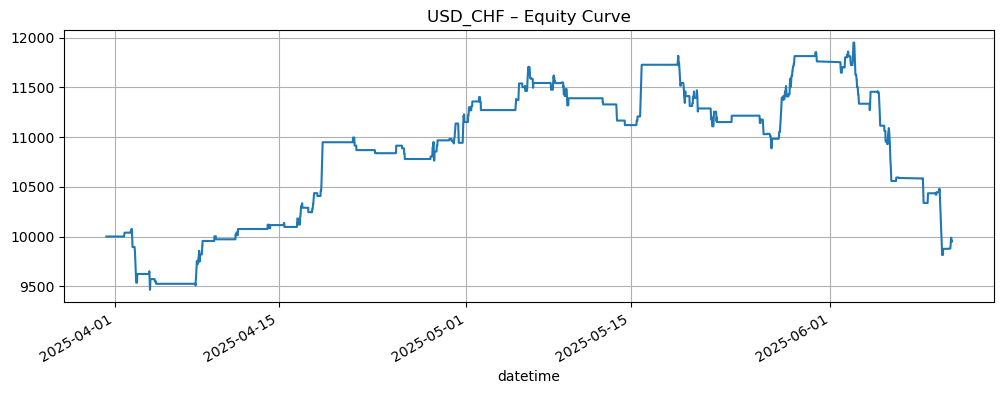


📊 Performance Summary Across Instruments:
Instrument  Total Return (%)  Win Rate (%)  Max Drawdown (%)  Profit Factor  Sharpe Ratio  Trades Taken                Start Date                  End Date
   EUR_USD              9.20         56.90             12.37           1.17          1.35           141 2025-03-31 07:15:00+00:00 2025-06-11 09:00:00+00:00
   GBP_USD             42.28         63.38              4.46           1.94          5.54           116 2025-03-31 07:00:00+00:00 2025-06-11 09:00:00+00:00
   AUD_USD             25.57         55.39              8.99           1.33          2.96           110 2025-03-31 07:15:00+00:00 2025-06-11 09:00:00+00:00
   NZD_USD             17.99         53.58             13.94           1.28          2.36            86 2025-03-31 07:15:00+00:00 2025-06-11 09:00:00+00:00
   USD_CHF             -0.50         51.34             17.88           1.00         -0.04           136 2025-03-31 07:00:00+00:00 2025-06-11 09:00:00+00:00


In [19]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# --- Step 1: Fetch Historical Data ---
def fetch_data(instrument="EUR_USD", granularity="M15", count=10000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693",
                 environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)
    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c'])
    } for candle in r.response['candles']]
    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close']].copy()

# --- Step 2: Detect Swing Highs/Lows (No Lookahead Bias) ---
def detect_swings(df, window=15):
    df = df.copy()
    
    # Use local extrema from past only
    df['swing_high'] = df['high'][argrelextrema(df['high'].values, np.greater, order=window)[0]]
    df['swing_low'] = df['low'][argrelextrema(df['low'].values, np.less, order=window)[0]]

    # Forward fill to maintain levels
    df['swing_high'] = df['swing_high'].ffill(limit=window*2)
    df['swing_low'] = df['swing_low'].ffill(limit=window*2)

    return df

# --- Step 3: Calculate Fibonacci Levels From Last Swing ---
def calculate_fib_levels(df):
    df = df.copy()
    df['diff'] = df['swing_high'] - df['swing_low']
    df['Level_0.382'] = df['swing_high'] - 0.382 * df['diff']
    df['Level_0.618'] = df['swing_high'] - 0.618 * df['diff']
    return df

# --- Step 4: Apply Strategy Logic – Fib + EMA Trend Filter ---
def apply_strategy(df, tolerance=0.0012):  # ~0.12%
    df = df.copy()
    capital = 10000
    risk_per_trade = 0.005  # 0.5% per trade
    fixed_sl_pips = 0.0012  # ~12 pips on majors

    # Trend Filter
    df['ema_200'] = df['close'].ewm(200).mean()
    df['trend'] = np.where(df['close'] > df['ema_200'], 'Uptrend', 'Downtrend')

    # Entry Signal – Buy when price near 0.618 AND trend matches
    df['buy_signal'] = ((df['trend'] == 'Uptrend') &
                        (abs(df['close'] - df['Level_0.618']) / df['close'] < tolerance))
    df['sell_signal'] = ((df['trend'] == 'Downtrend') &
                         (abs(df['close'] - df['Level_0.618']) / df['close'] < tolerance))

    # Track entry price
    df['entry_price'] = np.nan
    df.loc[df['buy_signal'], 'entry_price'] = df['close']
    df.loc[df['sell_signal'], 'entry_price'] = df['close']
    df['entry_price'] = df['entry_price'].ffill().fillna(0)

    # Stop Loss & Take Profit
    df['sl_long'] = df['entry_price'] - fixed_sl_pips
    df['tp_long'] = df['entry_price'] + fixed_sl_pips * 2
    df['sl_short'] = df['entry_price'] + fixed_sl_pips
    df['tp_short'] = df['entry_price'] - fixed_sl_pips * 2

    # Exit Signals
    df['exit_long'] = (df['close'] <= df['sl_long']) | (df['close'] >= df['tp_long'])
    df['exit_short'] = (df['close'] >= df['sl_short']) | (df['close'] <= df['tp_short'])

    # Generate Positions
    df['position'] = np.nan
    df.loc[df['buy_signal'], 'position'] = 1
    df.loc[df['sell_signal'], 'position'] = -1
    df.loc[df['exit_long'] | df['exit_short'], 'position'] = 0
    df['position'] = df['position'].ffill().fillna(0)

    # Position Sizing Based on Risk
    df['position_size'] = (capital * risk_per_trade) / fixed_sl_pips
    df['position_size'] = df['position_size'].clip(upper=100000)  # Cap position size

    # PnL Calculation
    long_return = ((df['close'] - df['entry_price']) / fixed_sl_pips) * risk_per_trade
    short_return = ((df['entry_price'] - df['close']) / fixed_sl_pips) * risk_per_trade
    df['pnl'] = np.where(df['position'] == 1, long_return,
                         np.where(df['position'] == -1, short_return, 0))
    df['pnl'] = df['pnl'].replace([np.inf, -np.inf], 0).fillna(0)
    df['strategy_returns'] = df['pnl'].shift()
    df['equity_curve'] = (df['strategy_returns'] + 1).cumprod() * capital

    return df

# --- Step 5: Run Backtests Across Multiple Instruments ---
instruments = ["EUR_USD", "GBP_USD", "AUD_USD", "NZD_USD", "USD_CHF"]
summary = []

print("📊 Running Fib Pullback Strategy Across Multiple Instruments:\n")

for instrument in instruments:
    try:
        df = fetch_data(instrument, granularity="M15", count=5000)
        df = detect_swings(df, window=15)
        df = calculate_fib_levels(df)
        df = apply_strategy(df)

        total_return = (df['equity_curve'].iloc[-1] - 10000) / 10000 * 100
        num_trades = df['position'].diff().abs().sum() / 2
        win_rate = np.mean(df['strategy_returns'][df['strategy_returns'] != 0] > 0) if any(df['strategy_returns'] != 0) else 0

        # Sharpe Ratio
        sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 16)

        # Profit Factor
        gross_profit = df['strategy_returns'][df['strategy_returns'] > 0].sum()
        gross_loss = abs(df['strategy_returns'][df['strategy_returns'] < 0].sum())
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

        # Max Drawdown
        df['peak'] = df['equity_curve'].cummax()
        df['drawdown'] = (df['peak'] - df['equity_curve']) / df['peak'] * 100
        max_drawdown = df['drawdown'].max()

        # Time Range
        start_date = df.index[0]
        end_date = df.index[-1]
        years = (end_date - start_date).days / 365

        print(f"\n📊 {instrument}")
        print(f" Backtest Period: {start_date} → {end_date}")
        print(f" Duration: ~{years:.1f} years")
        print(f" Total Return: {total_return:.2f}%")
        print(f" Win Rate: {win_rate * 100:.1f}%")
        print(f" Max Drawdown: {max_drawdown:.2f}%")
        print(f" Profit Factor: {profit_factor:.2f}")
        print(f" Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f" Final Equity: ${df['equity_curve'].iloc[-1]:.2f}")

        summary.append({
            'Instrument': instrument,
            'Total Return (%)': total_return,
            'Win Rate (%)': win_rate * 100,
            'Max Drawdown (%)': max_drawdown,
            'Profit Factor': profit_factor,
            'Sharpe Ratio': sharpe_ratio,
            'Trades Taken': int(num_trades),
            'Start Date': start_date,
            'End Date': end_date
        })

        # Plot equity curve
        df['equity_curve'].plot(title=f"{instrument} – Equity Curve", figsize=(12, 4), grid=True)
        plt.show()

    except Exception as e:
        print(f"📊 Error on {instrument}: {str(e)}")
        summary.append({
            'Instrument': instrument,
            'Total Return (%)': np.nan,
            'Win Rate (%)': np.nan,
            'Max Drawdown (%)': np.nan,
            'Profit Factor': np.nan,
            'Sharpe Ratio': np.nan,
            'Trades Taken': 0
        })

# --- Step 6: Summary Table ---
summary_df = pd.DataFrame(summary).round(2)
print("\n📊 Performance Summary Across Instruments:")
print(summary_df.to_string(index=False))